In [93]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [94]:
img_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [95]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size= Batch_size
)

Found 2152 files belonging to 3 classes.


In [96]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [97]:
len(dataset)

68

why 68 ?
- i have used a batch 32 [68*32]=2176 , bcoz last batch may have less data.
- Every element in a dataset is a batch of 32 images.

In [98]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape,'/n', label_batch)

(32, 256, 256, 3) /n tf.Tensor([0 2 1 1 0 0 1 2 1 1 1 1 0 1 1 0 0 0 1 1 1 0 2 1 1 2 0 1 1 0 0 0], shape=(32,), dtype=int32)


In [99]:
# converting to numpy 
label_batch.numpy()

array([0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       2, 1, 1, 2, 0, 1, 1, 0, 0, 0])

- 0, 1, 2 represent the classes of the datasets

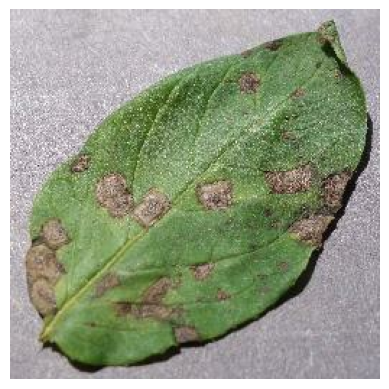

In [100]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype('uint8'))
    # print(image_batch[0])
    plt.axis('off')

- Data Type Conversion: It changes the data type of each element in the array or DataFrame to an unsigned 8-bit integer. An unsigned 8-bit integer can represent values in the range of 0 to 255. This is useful when you want to work with data that has a limited range of values and want to save memory or ensure that the data is in a specific format.

- Clipping Values: If any values in the original data exceed 255, they will be "clipped" or truncated to 255 (the maximum value representable by a uint8). Similarly, if there are negative values, they will wrap around to the higher end of the range.

In [101]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

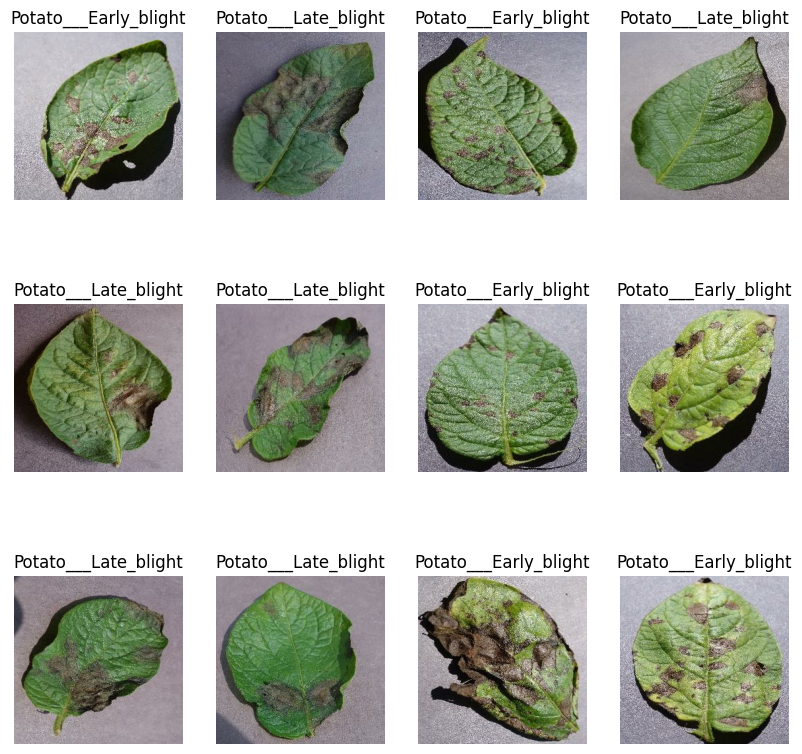

In [102]:
# lets display with label.
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): #taking batch '1'.
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        # print(image_batch[0])
        plt.axis('off')

- spiltting data:
- 80% -train
- 20% 
 - -10% validation- 10% test

In [103]:
def get_dataset_partitions_tf(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * dataset_size)
    validation_size = int(validation_split * dataset_size)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)

    return train_dataset, train_dataset, test_dataset

In [104]:
get_dataset_partitions_tf(dataset)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [105]:
len(test_dataset)

14

In [106]:
train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

- The code snippet you provided appears to be part of a machine learning or deep learning pipeline using a dataset object, which is likely from a library like TensorFlow or PyTorch. Let me break down what each part of this code does:

- train_dataset: This likely represents a dataset object that contains your training data. Datasets are often used in machine learning to efficiently load and process large amounts of data.

- cache(): The cache() method is used to cache the elements of the dataset in memory. Caching can significantly speed up training because it prevents the data from being reloaded from disk in each epoch. Instead, it is loaded into memory once and reused.

- shuffle(1000): The shuffle() method shuffles the elements of the dataset. The 1000 is an argument that specifies the buffer size for shuffling. It means that the dataset will maintain a buffer of 1000 elements and randomly sample from this buffer to shuffle the data. Shuffling is important to ensure that the model does not overfit to the order of the data during training.

- prefetch(): The prefetch() method is used to prefetch elements from the dataset. Prefetching allows the data loading and preprocessing to be done in parallel with the model training. It helps to keep the GPU or CPU busy with data processing, reducing potential bottlenecks.

- However, there is a missing argument in the prefetch() method. You should specify the number of elements to prefetch. For example, you can use prefetch(1) to prefetch one element at a time or prefetch(tf.data.experimental.AUTOTUNE) to let TensorFlow automatically choose the optimal prefetching buffer size based on available system 

In [107]:
# Preprocessing- scaling.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
    ])

''' the scaling factor is set to 1.0/255, 
    which means that each pixel value in the input images will be divided by 255. 
    This rescaling operation brings the pixel values into the range [0, 1].'''

In [108]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
'''This means that the layer will randomly rotate each input image by an angle between -0.2 and 0.2 radians.
(or approximately -11.46 to 11.46 degrees) during training.'''

'This means that the layer will randomly rotate each input image by an angle between -0.2 and 0.2 radians.\n(or approximately -11.46 to 11.46 degrees) during training.'

 # **Building Model-CNN**

In [109]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
        layers.Conv2D(
        32, (3,3), activation='relu', 
        input_shape =(Batch_size, img_size, img_size, Channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
    ])

model.build(input_shape = (Batch_size, img_size, img_size, Channels))

In [115]:
len(class_names)

3

In [3]:
model.summary()

NameError: name 'model' is not defined

**Complie**

In [125]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

- loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False): The loss argument specifies the loss function that the model will optimize during training. Here, you're using SparseCategoricalCrossentropy as the loss function. This loss function is commonly used for classification tasks when the labels are provided as integers (e.g., class indices). The from_logits=False argument indicates that the model's output is not raw logits (unnormalized class scores); it's the output probabilities of each class.

- metrics=["accuracy"]: The metrics argument is a list of metrics used to evaluate the model's performance during training. In this case, you're using the "accuracy" metric, which measures how well the model predicts the correct class labels.

In [126]:
history = model.fit(
    train_dataset,
    epochs=5,
    batch_size=Batch_size,
    verbose = 1,
    validation_data = validation_dataset,
)

Epoch 1/5
54/54 [==============================] - 348s 6s/step - loss: 0.8444 - accuracy: 0.5793 - val_loss: 0.6981 - val_accuracy: 0.6810
Epoch 2/5
54/54 [==============================] - 285s 5s/step - loss: 0.4902 - accuracy: 0.7882 - val_loss: 0.3140 - val_accuracy: 0.8707
Epoch 3/5
54/54 [==============================] - 234s 4s/step - loss: 0.3459 - accuracy: 0.8600 - val_loss: 0.3259 - val_accuracy: 0.8707
Epoch 4/5
54/54 [==============================] - 238s 4s/step - loss: 0.2670 - accuracy: 0.8976 - val_loss: 0.2287 - val_accuracy: 0.9138
Epoch 5/5
54/54 [==============================] - 189s 3s/step - loss: 0.2169 - accuracy: 0.9178 - val_loss: 0.2934 - val_accuracy: 0.8966


- In TensorFlow, the History callback is not something that you explicitly create; instead, it's automatically generated and returned when you fit a model using the model.fit() method. The History callback is a container that stores the training metrics and loss values at the end of each epoch. You can use this information for plotting training curves or analyzing model performance.

In [127]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [130]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [132]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training & Validation Loss')

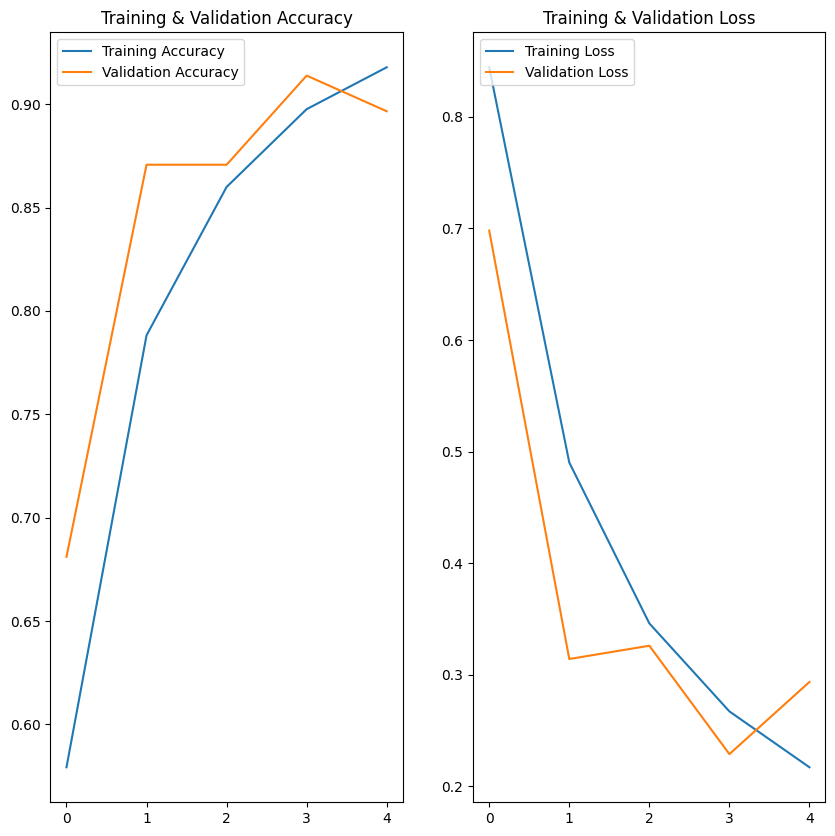

In [136]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(5), acc, label="Training Accuracy")
plt.plot(range(5), val_acc, label="Validation Accuracy")
plt.legend(loc="upper left")
plt.title("Training & Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(5), loss, label="Training Loss")
plt.plot(range(5), val_loss, label="Validation Loss")
plt.legend(loc="upper left")
plt.title("Training & Validation Loss")

Actual Label: Potato___Late_blight
1/1 [==============================] - 4s 4s/step
Batch Prediction: 2


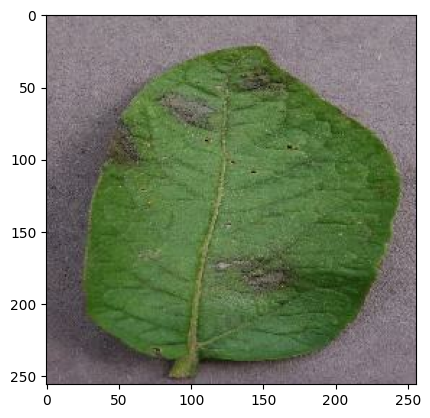

In [150]:
for image_batch, label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')

    plt.imshow(first_image)
    print("Actual Label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Batch Prediction:",np.argmax(batch_prediction[0]))

In [155]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100* (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 102ms/step


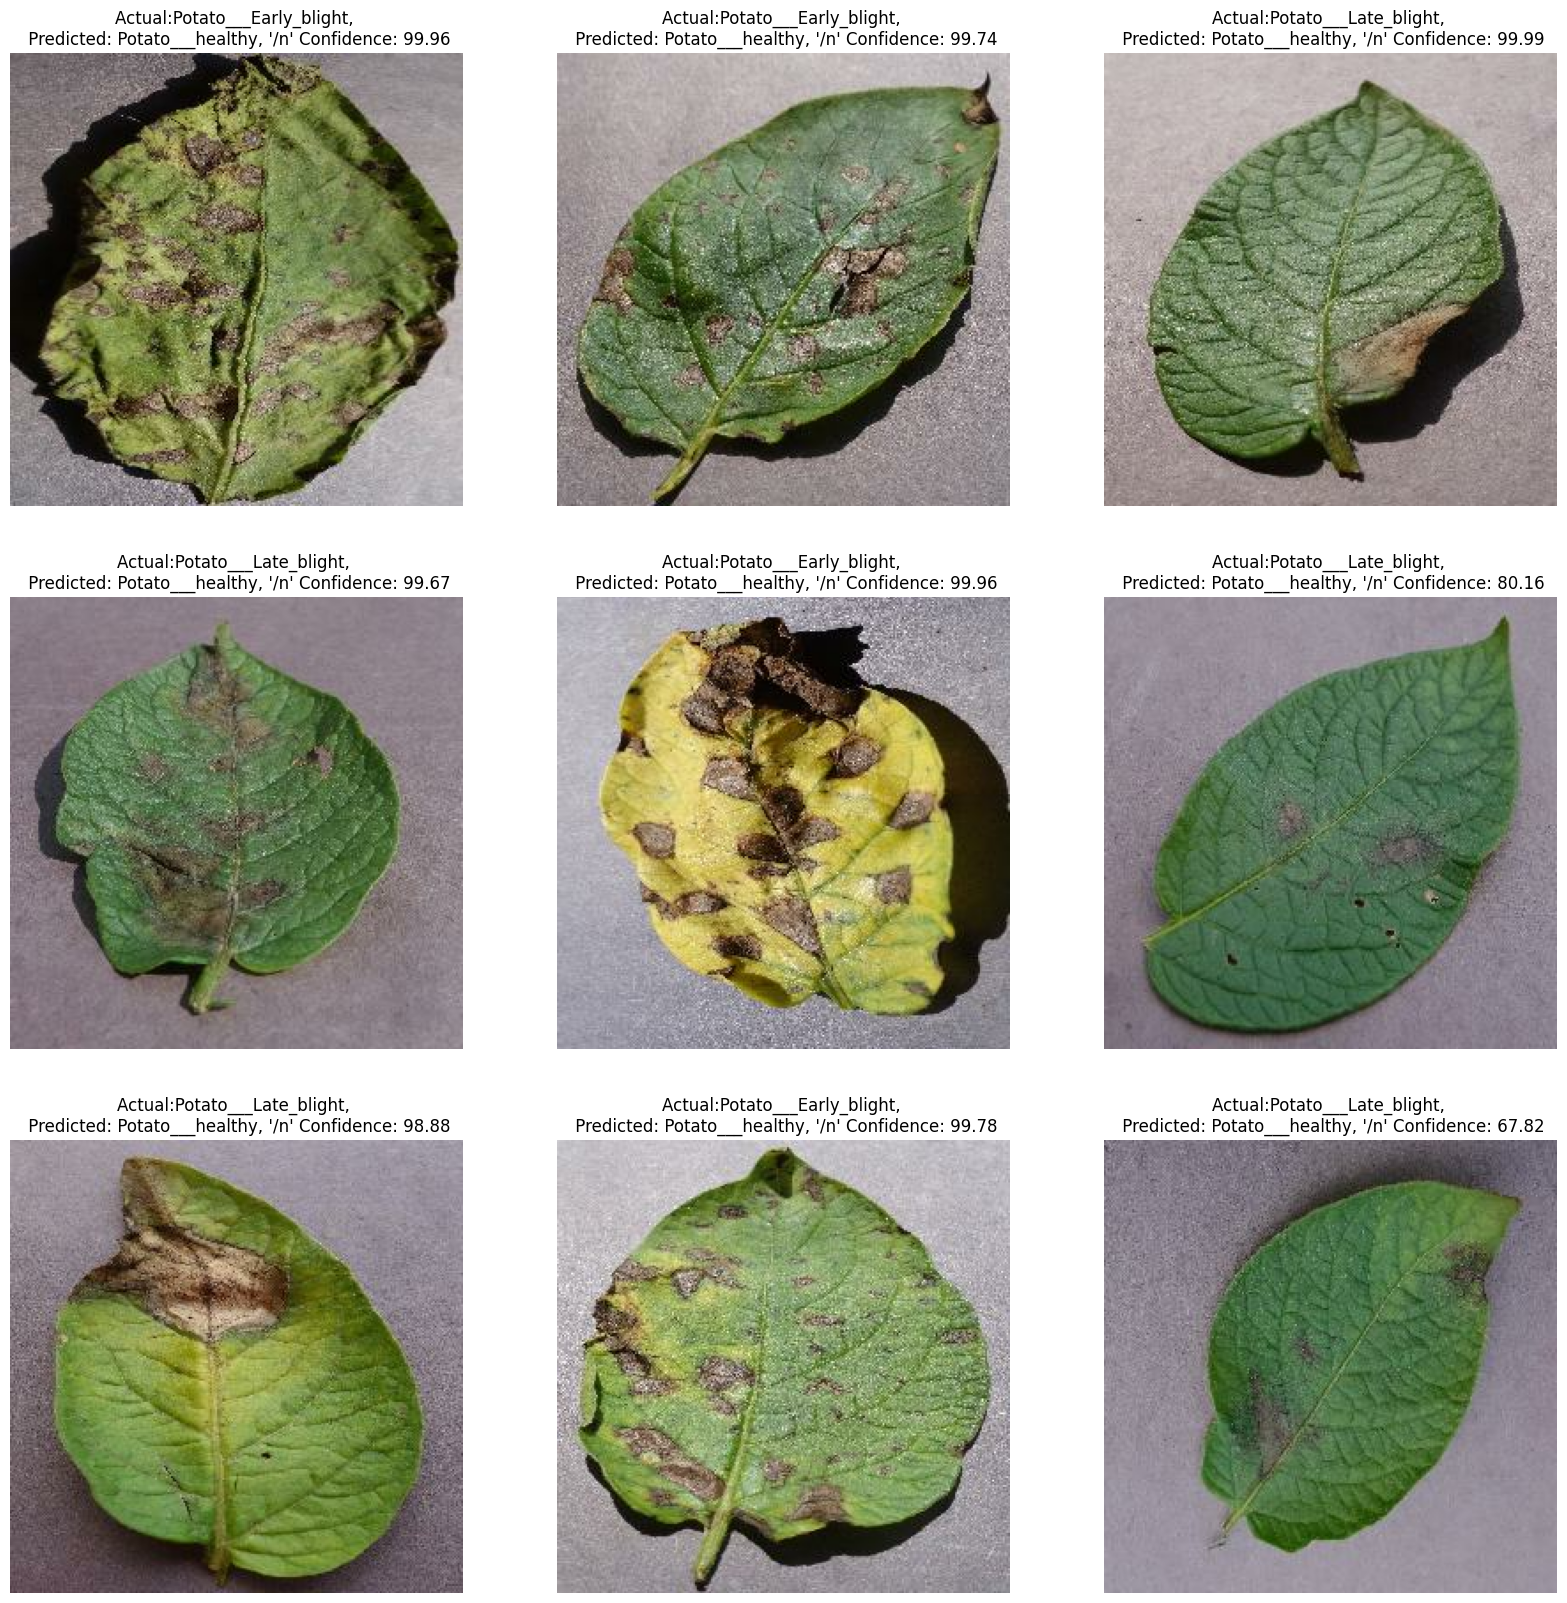

In [159]:
plt.figure(figsize=(20,20))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidense = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}, '/n' Confidence: {confidense}")
        plt.axis('off')

In [2]:
model_version = 1
model.save(f"../models/{model_version}")

NameError: name 'model' is not defined